## load the DB and explore

In [ ]:
# create a connection
import pandas as pd
import sqlite3

con = sqlite3.connect(r"C:\Users\welde\Desktop\delivery-market-analysis\delivery-market-analysis\data\takeaway.db")
objects = pd.read_sql_query("""
SELECT name, type
FROM sqlite_master
WHERE type IN ('table','view')
ORDER BY type, name;
""", con)

objects



name   type
0                categories  table
1    categories_restaurants  table
2                 locations  table
3  locations_to_restaurants  table
4                 menuItems  table
5               restaurants  table
6           sqlite_sequence  table

## helper 

In [29]:
def q(sql: str, params=None) -> pd.DataFrame:
    return pd.read_sql_query(sql, con, params=params)


## columns check

In [72]:
tables = [
    "categories",
    "restaurants",
    "menuItems",
    "locations",
    "locations_to_restaurants",
    "categories_restaurants",
]

for t in tables:
    print(f"\n=== {t} ===")
    display(q(f'PRAGMA table_info("{t}");'))


=== categories ===


cid           name type  notnull dflt_value  pk
0    0             id             0       None   0
1    1  restaurant_id             0       None   0
2    2           name             0       None   0
3    3        item_id             0       None   0


=== restaurants ===


cid              name     type  notnull dflt_value  pk
0     0       primarySlug     TEXT        0       None   1
1     1     restaurant_id                 0       None   0
2     2              name     TEXT        0       None   0
3     3           address     TEXT        0       None   0
4     4              city     TEXT        0       None   0
5     5  supportsDelivery     TEXT        0       None   0
6     6    supportsPickup                 0       None   0
7     7    paymentMethods     TEXT        0       None   0
8     8           ratings   NUMBER        0       None   0
9     9     ratingsNumber  INTEGER        0       None   0
10   10   deliveryScoober     TEXT        0       None   0
11   11  durationRangeMin  INTEGER        0       None   0
12   12  durationRangeMax  INTEGER        0       None   0
13   13       deliveryFee                 0       None   0
14   14          minOrder  INTEGER        0       None   0
15   15         longitude   NUMBER        0       None   0
16   16          latitude   NUMBER        0       None   0


=== menuItems ===


cid             name  type  notnull dflt_value  pk
0    0      primarySlug              0       None   1
1    1               id              0       None   2
2    2             name  TEXT        0       None   0
3    3      description  TEXT        0       None   0
4    4            price              0       None   0
5    5   alcoholContent              0       None   0
6    6  caffeineContent              0       None   0


=== locations ===


cid        name     type  notnull dflt_value  pk
0    0          ID  INTEGER        0       None   1
1    1  postalCode  INTEGER        0       None   0
2    2    latitude   NUMBER        0       None   0
3    3   longitude   NUMBER        0       None   0
4    4        city                 0       None   0
5    5        name                 0       None   0


=== locations_to_restaurants ===


cid           name     type  notnull dflt_value  pk
0    0  restaurant_id                 0       None   0
1    1    location_id  INTEGER        0       None   0


=== categories_restaurants ===


cid           name type  notnull dflt_value  pk
0    0    category_id             0       None   1
1    1  restaurant_id             0       None   2

In [ ]:
check1 = q("""SELECT COUNT(*) AS matched
FROM locations_to_restaurants ltr
JOIN restaurants r ON r.primarySlug = ltr.restaurant_id;""")
check1


matched
0   157809

# Quick data quality  check

In [ ]:
queries = {
    "Restaurant row count": "SELECT COUNT(*) AS n FROM restaurants;",
    "Menu item row count": "SELECT COUNT(*) AS n FROM menuItems;",
    "Missing values in restaurants": """
        SELECT
          SUM(CASE WHEN ratings IS NULL THEN 1 ELSE 0 END) AS missing_rating,
          SUM(CASE WHEN ratingsNumber IS NULL THEN 1 ELSE 0 END) AS missing_rating_count,
          SUM(CASE WHEN latitude IS NULL OR longitude IS NULL THEN 1 ELSE 0 END) AS missing_coords
        FROM restaurants;
    """,
    "Missing prices in menuItems": """
        SELECT
          SUM(CASE WHEN price IS NULL THEN 1 ELSE 0 END) AS missing_price
        FROM menuItems;
    """
}

results = {title: q(sql) for title, sql in queries.items()}

for title, df in results.items():
    print(f"\n=== {title} ===")
    display(df)



=== Restaurant row count ===


n
0  4071


=== Menu item row count ===


n
0  403013


=== Missing values in restaurants ===


missing_rating  missing_rating_count  missing_coords
0               0                     0               0


=== Missing prices in menuItems ===


missing_price
0              0

# Create clean views

In [94]:
sql_clean_views = """
DROP VIEW IF EXISTS restaurants_clean;
CREATE VIEW restaurants_clean AS
SELECT
  primarySlug AS restaurant_key,
  name,
  city,
  CAST(ratings AS REAL)         AS rating,
  CAST(ratingsNumber AS INT)    AS rating_count,
  CAST(latitude AS REAL)        AS latitude,
  CAST(longitude AS REAL)       AS longitude,
  CAST(deliveryFee AS REAL)     AS delivery_fee,
  CAST(minOrder AS REAL)        AS min_order,
  CAST(durationRangeMin AS INT) AS eta_min,
  CAST(durationRangeMax AS INT) AS eta_max
FROM restaurants;

DROP VIEW IF EXISTS menuItems_clean;
CREATE VIEW menuItems_clean AS
SELECT
  primarySlug AS restaurant_key,
  name,
  description,
  CAST(price AS REAL) AS price
FROM menuItems
WHERE price IS NOT NULL
  AND TRIM(price) <> ''
  AND CAST(price AS REAL) > 0;
"""

con.executescript(sql_clean_views)

# quick checks (these are SELECTs, so q() is appropriate)
q('SELECT * FROM restaurants_clean LIMIT 5;')
q('SELECT * FROM menuItems_clean LIMIT 5;')


restaurant_key            name  \
0  barouche-kortemunt      Hummus dip   
1  barouche-kortemunt    Seasonal dip   
2  barouche-kortemunt        BarBacon   
3  barouche-kortemunt     Chick(p)ita   
4  barouche-kortemunt  Steak Republic   

                                         description  price  
0  'Libanese hummus topped off with mango chutney...   6.95  
1                                                      6.95  
2  'Homemade sourdough pita bread filled with sal...  12.95  
3  'Homemade sourdough pita bread filled with sal...  13.95  
4  'Homemade sourdough pita bread filled with sal...  14.95

## 1. Categories

In [55]:
import pandas as pd

categories = q('SELECT * FROM categories order by name;')
categories.head(1000)

id          restaurant_id                           name  \
0    NPP5O7NO    pizza-service-diest  !Dinsdag/zaterdag! - pizzadag   
1    NPP5O7NO    pizza-service-diest  !Dinsdag/zaterdag! - pizzadag   
2    NPP5O7NO    pizza-service-diest  !Dinsdag/zaterdag! - pizzadag   
3    NPP5O7NO    pizza-service-diest  !Dinsdag/zaterdag! - pizzadag   
4    NPP5O7NO    pizza-service-diest  !Dinsdag/zaterdag! - pizzadag   
..        ...                    ...                            ...   
995  NQ1POR0P  sushi-shop-waterloo-1                Accompagnements   
996  NQ1POR0P  sushi-shop-waterloo-1                Accompagnements   
997  NQ1POR0P  sushi-shop-waterloo-1                Accompagnements   
998  NQ1POR0P  sushi-shop-waterloo-1                Accompagnements   
999  NQ1POR0P  sushi-shop-waterloo-1                Accompagnements   

        item_id  
0     NR5RO31RP  
1     NNPRO31RP  
2     N5PRO31RP  
3     NQPRO31RP  
4     N17RO31RP  
..          ...  
995   N711RR7RP  
996   N0N1RR7RP  
997   NRN1RR7RP  
998  O1Q117R0O1  
999   N3N1RR7RP  

[1000 rows x 4 columns]

## 2. Categories- restaurants

In [ ]:
import pandas as pd

categories_restaurants = q('SELECT *  FROM categories_restaurants;')
categories_restaurants.head(100)

category_id   restaurant_id
0  burgers_1984  kings-boutique
1    fries_1734  kings-boutique
2   chicken_521  kings-boutique
3          2600  kings-boutique

## 3. Locations

In [6]:
import pandas as pd

locations = q("""SELECT * FROM locations
              order by id desc;""")
locations.head(100)

ID  postalCode   latitude  longitude               city  \
0   2504        9400  50.818995   3.966288  Appelterre-Eichem   
1   2503        8660  51.101270   2.591424           De Panne   
2   2502        1755  50.773008   4.063802           Oetingen   
3   2501        9470  50.877341   4.065128        Denderleeuw   
4   2500        9680  50.816185   3.653858          Maarkedal   
..   ...         ...        ...        ...                ...   
95  2409        9300  50.940756   4.030959              Aalst   
96  2408        8340  51.201245   3.322646              Damme   
97  2407        9000  51.062663   3.723754              Ghent   
98  2406        9000  51.057038   3.716593              Ghent   
99  2405        9000  51.022701   3.701488              Ghent   

                                        name  
0                         Sint-Gertrudiskerk  
1                       Onze-Lieve-Vrouwkerk  
2                          Sint-Ursmaruskerk  
3              Onze-Lieve-Vrouw ter Noodkerk  
4                                  Het Marca  
..                                       ...  
95    Onze-Lieve-Vrouw van Meuleschettekapel  
96                         Sint-Martinuskerk  
97  Psychiatrisch Ziekenhuis Sint-Jan de Deo  
98                   Kerk Paters Karmelieten  
99                       Maaltebruggekasteel  

[100 rows x 6 columns]

## 4. Locations_to_restuarants

In [ ]:
import pandas as pd

locations_to_restaurants = q('SELECT * FROM locations_to_restaurants order by restaurant_id;')
locations_to_restaurants.head(100)

restaurant_id  location_id
0          chitir-chicken-ninove            0
1                         hkebab            0
2                   juicy-ninove            0
3                          samis            0
4                      josephine            0
..                           ...          ...
95                    miss-pizza            3
96            pizza-hot-kruibeke            3
97             the-daily-beveren            3
98  king-pizza-more-sint-niklaas            3
99                  frituur-1830            3

[100 rows x 2 columns]

## 5. Menu items

In [45]:
import pandas as pd

menuitems = q('SELECT * FROM menuitems ' \
'order by primarySlug;')
menuitems .head(100)

primarySlug          id                                name  \
0        18-sushi   N005Q71P7                             Edamame   
1        18-sushi   N0N1QP077                     Yasai hand roll   
2        18-sushi   N0NPQ71P7              Mangajo green tea acai   
3        18-sushi   N0P3771P7             Small poké bowl chicken   
4        18-sushi   N0PP771P7                         Nigiri tuna   
..            ...         ...                                 ...   
95       18-sushi   ORQQQQQOR             Sashimi mix (15 pieces)   
96       18-sushi  R11QR7R1Q1  Gefrituurde tuna avocado (12stuks)   
97       18-sushi  R3PR3RR5P1                           Tofu roll   
98       18-sushi  ROQ35PP0P1            Sashimi salmon (15stuks)   
99  2bangkok-thai  3737P0QN51                       Mix bangkok 2   

                                          description  price alcoholContent  \
0                                                        3.5              0   
1                     'Vegetables, cocktail, sesame.'    5.0              0   
2                                                        2.8              0   
3   'Edamame, corn, cucumber, bell pepper, peppers...   10.5              0   
4                                             'Tuna.'    4.0              0   
..                                                ...    ...            ...   
95                             '8 salmon and 7 tuna.'   22.5              0   
96                                 'Tonijn, avocado.'   11.0              0   
97                           'Tofu,komkommer,avocado'    7.5              0   
98                                             'Zalm'   19.5              0   
99  'Spring roll chicken x3, chicken satay x3, tod...   27.5              0   

   caffeineContent  
0                0  
1                0  
2                0  
3                0  
4                0  
..             ...  
95               0  
96               0  
97               0  
98               0  
99               0  

[100 rows x 7 columns]

In [28]:
missing = q("""
SELECT
  SUM(CASE WHEN price IS NULL THEN 1 ELSE 0 END) AS missing_price
FROM menuItems;
""")
missing


missing_price
0              0

## 6. Restuarants

In [9]:

import pandas as pd

restaurants = q('SELECT * FROM restaurants;')
restaurants.head()




primarySlug restaurant_id                    name  \
0                pasta-pino      ONPO70QN              Pasta Pino   
1         da-barone-et-fils      00N7P37N       Da Barone et Fils   
2             pizza-gustosa      O031NNN1           Pizza Gustosa   
3  la-brezza-nova-rocourt-1      R0P3NPQN  La Brezza Nova Rocourt   
4             la-storia-ans      R5R5QNQN               La Storia   

                     address      city supportsDelivery  supportsPickup  \
0          Rue de Tournai 28  Mouscron                1               1   
1       route du condroz 202    Neupré                1               1   
2       Rue de Bruxelles 110     Awans                1               1   
3  Rue François-Lefèbvre 192     Liège                1               0   
4          Rue de l'yser 409     Liège                1               1   

                                   paymentMethods  ratings  ratingsNumber  \
0          ['bancontact', 'paypal', 'creditcard']      4.6             29   
1  ['bancontact', 'cash', 'paypal', 'creditcard']      3.0            139   
2  ['bancontact', 'cash', 'paypal', 'creditcard']      4.6           1382   
3          ['bancontact', 'paypal', 'creditcard']      4.3              8   
4          ['bancontact', 'paypal', 'creditcard']      4.2             10   

  deliveryScoober  durationRangeMin  durationRangeMax  deliveryFee  minOrder  \
0               0                15                40          3.0      15.0   
1               0                80               100          3.0      10.0   
2               0                20                45          4.0      25.0   
3               0                40                65          5.0      30.0   
4               0                45                70          5.0      55.0   

   longitude   latitude  
0   3.216888  50.743630  
1   5.460752  50.540992  
2   5.480206  50.675491  
3   5.549703  50.684180  
4   5.512421  50.663340

In [ ]:
restaurants = q('SELECT count(restaurant_id) FROM restaurants;')
restaurants.head()


## 7. sqlte_squence

In [10]:
schema = q("""SELECT * FROM sqlite_sequence;
""")



#  --------------------ANALYSIS-----------------

## 1. Price distribution in menuitems

In [11]:
prices_df = q("""
SELECT price
FROM menuItems
WHERE price IS NOT NULL;
""")

prices_df.head(100)

price
0    6.95
1    6.95
2   12.95
3   13.95
4   14.95
..    ...
95  17.50
96  16.50
97  16.95
98  16.50
99  16.50

[100 rows x 1 columns]

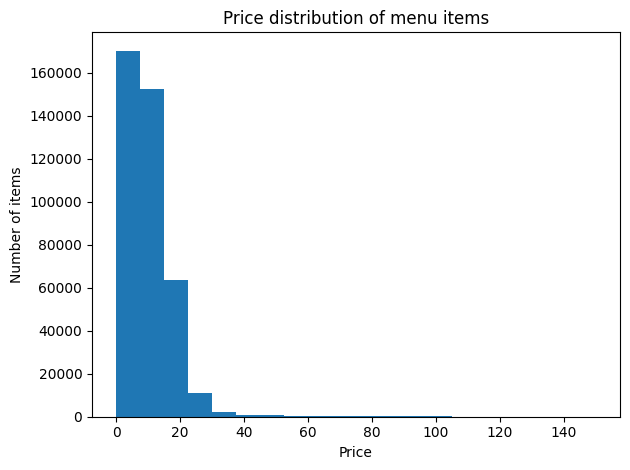

In [15]:
import matplotlib.pyplot as plt
plt.hist(prices_df["price"], bins=20)
plt.title("Price distribution of menu items")
plt.xlabel("Price")
plt.ylabel("Number of items")
plt.tight_layout()
plt.show()

In [ ]:
bucket_counts = q("""
SELECT
  (CAST(price / 5 AS INT) * 5) AS bucket_start,
  (CAST(price / 5 AS INT) * 5) + 5 AS bucket_end,
  COUNT(*) AS n_items
FROM menuItems
WHERE price IS NOT NULL
GROUP BY bucket_start
ORDER BY bucket_start;
""")
bucket_counts



In [ ]:
plt.figure()
labels = bucket_counts["bucket_start"].astype(int).astype(str) + "-" + bucket_counts["bucket_end"].astype(int).astype(str)
plt.bar(labels, bucket_counts["n_items"])
plt.title("Price distribution of menu items (bucket size = 5)")
plt.xlabel("Price range")
plt.ylabel("Number of items")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## 2 . distribution of restaurants per location

In [19]:
restaurants_map = q(""" select count(DISTINCT
    restaurant_id) as num_of_restaurants, city from restaurants
    GROUP BY city
    ORDER BY num_of_restaurants DESC
    LIMIT 100;""")
restaurants_map.head(100)

num_of_restaurants        city
0                  437   Antwerpen
1                  309        Gent
2                  264   Bruxelles
3                  174      Leuven
4                  110  Schaerbeek
..                 ...         ...
95                   8      Anvers
96                   8    Aarschot
97                   7    Zonhoven
98                   7     Zelzate
99                   7  Willebroek

[100 rows x 2 columns]

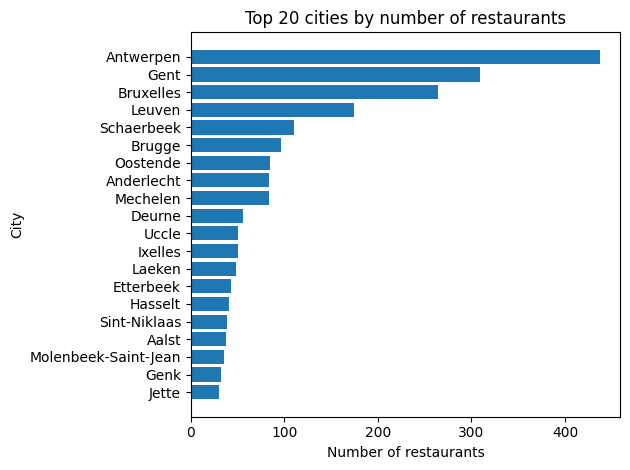

In [20]:
import matplotlib.pyplot as plt

top = restaurants_map.head(20).sort_values("num_of_restaurants")

plt.figure()
plt.barh(top["city"], top["num_of_restaurants"])
plt.title("Top 20 cities by number of restaurants")
plt.xlabel("Number of restaurants")
plt.ylabel("City")
plt.tight_layout()
plt.show()


In [21]:
restaurants_map = q("""
SELECT
  name,
  latitude,
  longitude,
  city
FROM restaurants
WHERE latitude IS NOT NULL
  AND longitude IS NOT NULL;
""")
restaurants_map.head()

name   latitude  longitude      city
0              Pasta Pino  50.743630   3.216888  Mouscron
1       Da Barone et Fils  50.540992   5.460752    Neupré
2           Pizza Gustosa  50.675491   5.480206     Awans
3  La Brezza Nova Rocourt  50.684180   5.549703     Liège
4               La Storia  50.663340   5.512421     Liège

In [30]:
import folium

# center the map around the average coordinates
center_lat = restaurants_map["latitude"].mean()
center_lon = restaurants_map["longitude"].mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=11)

# add points
for _, row in restaurants_map.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=3,
        popup=row["name"],   # click to see restaurant name
        fill=True
    ).add_to(m)

m



## The top 10 pizza restaurants by rating

In [65]:
pizza_ids = q("""
SELECT restaurant_id
FROM categories
WHERE name LIKE '%pizza%';
""")
pizza_ids

restaurant_id
0      kingslize-pizza-gent
1      kingslize-pizza-gent
2      kingslize-pizza-gent
3      kingslize-pizza-gent
4      kingslize-pizza-gent
...                     ...
70360    pitta-pizza-ludwig
70361    pitta-pizza-ludwig
70362    pitta-pizza-ludwig
70363    pitta-pizza-ludwig
70364    pitta-pizza-ludwig

[70365 rows x 1 columns]

In [64]:
pizza_restaurants = q("""
SELECT DISTINCT restaurant.*
FROM restaurants AS restaurant
JOIN categories  AS category
  ON restaurant.primarySlug = category.restaurant_id
WHERE category.name LIKE '%pizza%';
""")
pizza_restaurants

primarySlug restaurant_id                name  \
0                 kingslize-pizza-gent      ONPQP1N1     Kingslize Pizza   
1              dominos-pizza-mortsel-2      3NON7R7N      Domino's Pizza   
2                            pizza-ozy      OPOQPRPN           Pizza Ozy   
3     pizza-hut-delivery-deurne-zuid-2       O31N53R  Pizza Hut Delivery   
4                          heist-kebab      O5Q1RNNN         Heist Kebab   
...                                ...           ...                 ...   
1344                  mio-pasta-leuven      RQP3QOQN    Mio Pasta Leuven   
1345                dominos-pizza-bree      305RQ57N      Domino's Pizza   
1346                             sofra       N77OQQP               Sofra   
1347                      da-valentina       N5RNR57        Da Valentina   
1348                pitta-pizza-ludwig       Q707NQO  Pitta Pizza Ludwig   

                       address               city supportsDelivery  \
0     Willem Wenemaerstraat 62               Gent                1   
1                 Statielei 12            Mortsel                0   
2            Sleidinge Dorp 44          Sleidinge                1   
3            Herentalsebaan 98             Deurne                1   
4                Bergstraat 32  Heist-Op-Den-Berg                1   
...                        ...                ...              ...   
1344             Oude Markt 33             Leuven                1   
1345          Kloosterstraat 3               Bree                1   
1346       Dokter Haubenlaan 1       Maasmechelen                1   
1347        Avenue Seghers 115          Bruxelles                1   
1348        Sleidinge-Dorp 44a          Sleidinge                1   

      supportsPickup                                  paymentMethods  ratings  \
0                  1  ['bancontact', 'cash', 'paypal', 'creditcard']      3.8   
1                  1  ['bancontact', 'cash', 'paypal', 'creditcard']      3.9   
2                  1  ['bancontact', 'cash', 'paypal', 'creditcard']      3.2   
3                  0          ['bancontact', 'paypal', 'creditcard']      4.0   
4                  1  ['bancontact', 'cash', 'paypal', 'creditcard']      4.5   
...              ...                                             ...      ...   
1344               1          ['bancontact', 'paypal', 'creditcard']      0.0   
1345               1  ['bancontact', 'cash', 'paypal', 'creditcard']      3.7   
1346               1          ['bancontact', 'paypal', 'creditcard']      3.8   
1347               1          ['bancontact', 'paypal', 'creditcard']      4.6   
1348               1  ['bancontact', 'cash', 'paypal', 'creditcard']      3.6   

      ratingsNumber deliveryScoober  durationRangeMin  durationRangeMax  \
0              1297               0                20                45   
1                78               0                35                60   
2                38               0                30                55   
3               286               0                40                65   
4               230               0                20                45   
...             ...             ...               ...               ...   
1344              0               1                40                50   
1345             81               0                40                65   
1346            106               0                40                65   
1347            130               1                45                55   
1348           1697               0                50                75   

      deliveryFee  minOrder  longitude   latitude  
0            2.90      30.0   3.730763  51.038746  
1            0.00      12.0   4.451355  51.170433  
2            0.00      14.0   3.679667  51.132576  
3            1.99      15.0   4.456414  51.209320  
4            0.00      15.0   4.725220  51.075626  
...           ...       ...        ...        ...  
1344         2.99      10.0   4.698

In [66]:
top_pizza_restaurants = q("""
SELECT DISTINCT restaurant.*
FROM restaurants AS restaurant
JOIN categories  AS category
  ON restaurant.primarySlug = category.restaurant_id
WHERE category.name LIKE '%pizza%'
  AND restaurant.ratingsNumber > 10
ORDER BY restaurant.ratings DESC
LIMIT 10;
""")
top_pizza_restaurants

primarySlug restaurant_id                        name  \
0         kebap-pizza-de-brug      0QP1R37N       Kebap - Pizza De Brug   
1     eethuis-carlos-aarschot      ORRRO7N1     De Echte Eethuis Carlos   
2        trend-kebab-pizzeria      OO3503PN      Trend Kebab & Pizzeria   
3             the-black-horse       5O57P03             The Black Horse   
4             pyramide-hamont      3P5P7R7N                    Pyramide   
5             baskent-ohcange       OO0QRQP            Baskent Meerhout   
6                 more-pizzas      3ROR0Q7N                More pizza's   
7  pizzeria-zirar-saint-denis       N0O0R57  Pizzeria Zirar Saint-Denis   
8        dominos-pizza-geel-1      R57PQPQN              Domino's Pizza   
9               pizzeria-1357      31PO00QN               Pizzeria 1357   

                    address               city supportsDelivery  \
0   Sint-Truidersteenweg 46            Hasselt                1   
1     Herseltsesteenweg 207           Aarschot                1   
2             Marktstraat 1            Maaseik                0   
3             Bergstraat 36  Heist-op-den-Berg                1   
4         Stationsstraat 61             Hamont                1   
5      Bevrijdingslaan 231a           Meerhout                1   
6              De Biezen 26            Merksem                1   
7  Chaussée de Bruxelles 10             Forest                1   
8                  Markt 77               Geel                1   
9           Rue des Juifs 2           Helecine                1   

   supportsPickup                                     paymentMethods  ratings  \
0               0     ['bancontact', 'cash', 'paypal', 'creditcard']      5.0   
1               1     ['bancontact', 'cash', 'paypal', 'creditcard']      5.0   
2               1     ['bancontact', 'cash', 'paypal', 'creditcard']      5.0   
3               1     ['bancontact', 'cash', 'paypal', 'creditcard']      4.9   
4               1             ['bancontact', 'paypal', 'creditcard']      4.9   
5               1     ['bancontact', 'cash', 'paypal', 'creditcard']      4.9   
6               1     ['bancontact', 'cash', 'paypal', 'creditcard']      4.9   
7               1  ['bancontact', 'cash', 'paypal', 'creditcard',...      4.9   
8               1             ['bancontact', 'paypal', 'creditcard']      4.9   
9               1             ['bancontact', 'paypal', 'creditcard']      4.9   

   ratingsNumber deliveryScoober  durationRangeMin  durationRangeMax  \
0            312               0                20                45   
1            599               0                15                40   
2            165               0                20                45   
3            127               0                10                20   
4             45               0                25                50   
5            879               0                20                45   
6            311               0                15                40   
7            529               0                25                50   
8             19               0                20                30   
9             24               0                30                55   

   deliveryFee  minOrder  longitude   latitude  
0          0.0        20   0.000000   0.000000  
1          2.5        25   4.835920  51.002308  
2          3.5        20   5.792328  51.094082  
3          0.0        20   4.725100  51.075852  
4          3.0        15   5.545820  51.246120  
5          0.0        30   5.053922  51.121088  
6          2.0        40   4.452983  51.253255  
7          0.0        30   4.317642  50.810465  
8          0.0        50   4.989902  51.160737  
9          0.0        45   4.986744  50.753725